In [1]:
!pip uninstall -y google-generativeai google-ai-generativelanguage
!pip install -q -U langchain langchain-google-genai

Found existing installation: google-generativeai 0.8.5
Uninstalling google-generativeai-0.8.5:
  Successfully uninstalled google-generativeai-0.8.5
Found existing installation: google-ai-generativelanguage 0.6.15
Uninstalling google-ai-generativelanguage-0.6.15:
  Successfully uninstalled google-ai-generativelanguage-0.6.15
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 28.7 MB/s eta 0:00:00


In [25]:
import os
from google.colab import userdata

os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser


llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.7)

template = """
You are a helpful and creative writer.
Write a short, engaging story about a character named {character_name} who discovers a mysterious {object}.
"""
prompt = PromptTemplate(template=template, input_variables=["character_name", "object"])

story_chain = prompt | llm | StrOutputParser()

print("--- Running Refactored Text Generation Chain ---")
character_name = "Elara"
mysterious_object = "glowing crystal"
response = story_chain.invoke({"character_name": character_name, "object": mysterious_object})

print(response)

print("\n\n" + "="*50 + "\n\n")


summarization_template = """
Summarize the following text in a single, concise sentence:
{text}
"""
summarization_prompt = PromptTemplate(template=summarization_template, input_variables=["text"])

sentiment_template = """
Analyze the sentiment of the following summary. Is it positive, negative, or neutral?
Summary: {summary}
"""
sentiment_prompt = PromptTemplate(template=sentiment_template, input_variables=["summary"])

overall_chain = {"summary": summarization_prompt | llm | StrOutputParser()} | sentiment_prompt | llm | StrOutputParser()

print("--- Running Refactored Sequential Chain for Analysis ---")
long_text = """
The new software update has been widely praised for its intuitive design and seamless user experience.
Customers report a significant improvement in performance and stability, leading to higher satisfaction scores.
The company's stock price also saw a notable increase following the release.
"""
final_result = overall_chain.invoke({"text": long_text})

print("\n--- Final Analysis ---")
print(final_result)

--- Running Refactored Text Generation Chain ---
Elara, a wisp of a girl with eyes the color of moss and hair like spun moonlight, was known for two things: getting lost and finding the extraordinary. Today, she was lost, gloriously so, in the Whispering Woods, a place her grandmother warned held more secrets than stars.

Sunlight dripped through the canopy in fractured patterns, painting the forest floor in shifting mosaics. Elara, humming a tune only the wind understood, stumbled upon a clearing she’d never seen before. At its heart, nestled amongst the roots of an ancient oak, pulsed a light unlike any she'd witnessed.

It was a crystal, the size of her fist, radiating a soft, ethereal glow. The light shimmered, shifting between hues of lavender, emerald, and a deep, fathomless sapphire. It hummed with a low, resonant frequency that vibrated in Elara's bones. Cautiously, she reached out.

As her fingers brushed the smooth, cool surface, a jolt, not unpleasant, surged through her. Im

In [26]:
import os
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
from google.colab import userdata

# API Key
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

sample_text = """
The Gemini project was a series of ten manned spaceflights conducted by NASA between 1961 and 1966. Its primary objective was to develop and test the skills and technologies necessary for the Apollo missions. These included rendezvous and docking with other spacecraft, long-duration spaceflight, and extravehicular activity (EVA). The Gemini program's success was crucial for the United States to land a man on the Moon.
"""

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
docs = text_splitter.create_documents([sample_text])

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

vectorstore = FAISS.from_documents(docs, embeddings)

retriever = vectorstore.as_retriever()

#LLm Model
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.7)

prompt = ChatPromptTemplate.from_template("""
Answer the following question based only on the provided context.
If you do not know the answer, say "I don't have enough information to answer."

Context: {context}

Question: {input}
""")

document_chain = create_stuff_documents_chain(llm, prompt)

retrieval_chain = create_retrieval_chain(retriever, document_chain)

print("--- Running RAG Chain ---")

response = retrieval_chain.invoke({"input": "What was the main purpose of the Gemini project?"})

print(response["answer"])

print("\n--- Example of a question outside the context ---")

response = retrieval_chain.invoke({"input": "Who was the first person to walk on the moon?"})
print(response["answer"])

--- Running RAG Chain ---
The main purpose of the Gemini project was to develop and test the skills and technologies necessary for the Apollo missions.

--- Example of a question outside the context ---
I don't have enough information to answer.


In [27]:
import os
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage
from langgraph.graph import StateGraph, END

from pydantic import BaseModel, Field

os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

# Tools
tavily_tool = TavilySearchResults(max_results=5)
tools = [tavily_tool]

model = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0, tools=tools)


class AgentState(BaseModel):
    messages: list[BaseMessage] = Field(default_factory=list)
    class Config:
        arbitrary_types_allowed = True


def call_model(state: AgentState):

    messages = state.messages
    response = model.invoke(messages)
    return {"messages": [response]}


def call_tool(state: AgentState):

    last_message = state.messages[-1]


    tool_output = last_message.tool_calls[0]['args']['query']
    tool_name = last_message.tool_calls[0]['name']


    if tool_name == "tavily_search_results":
        result = tavily_tool.invoke({"query": tool_output})
    else:
        result = "Tool not found."


    return {"messages": [ToolMessage(content=str(result), tool_call_id=last_message.tool_calls[0].id)]}


graph_builder = StateGraph(AgentState)

graph_builder.add_node("agent", call_model)
graph_builder.add_node("tool", call_tool)

graph_builder.set_entry_point("agent")


def should_continue(state: AgentState):
    last_message = state.messages[-1]

    if last_message.tool_calls:
        return "tool"
    else:
        return "end"


graph_builder.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tool": "tool",
        "end": END
    }
)
graph_builder.add_edge('tool', 'agent')


graph = graph_builder.compile()


print("--- Running Multi-Agent System ---")
response = graph.invoke({"messages": [HumanMessage(content="What is the latest news about the Webb Space Telescope?")]})

final_answer = response['messages'][-1].content
print(final_answer)

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3553: UserWarning: WARNING! tools is not default parameter.
                tools was transferred to model_kwargs.
                Please confirm that tools is what you intended.
  exec(code_obj, self.user_global_ns, self.user_ns)


--- Running Multi-Agent System ---
Here's a summary of the latest news about the James Webb Space Telescope (JWST), focusing on recent highlights:

*   **JWST Spots Most Distant Galaxy Candidate Ever:** In May 2024, scientists announced the discovery of a potential galaxy, designated JADES-GS-z14-0, which existed just 290 million years after the Big Bang. If confirmed, this would be the most distant and earliest galaxy ever observed. The galaxy is surprisingly bright and large, challenging existing models of early galaxy formation.

*   **JWST Reveals New Details About Exoplanets:** JWST continues to provide unprecedented insights into exoplanets. Recent studies have used JWST to analyze the atmospheres of exoplanets, detecting molecules like methane, water vapor, and carbon dioxide. These observations help scientists understand the composition and potential habitability of these distant worlds.

*   **JWST Studies Star Formation in Galaxies:** JWST's infrared capabilities are ideal fo

In [28]:
import os
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
from langchain_core.tools import tool

# API Key
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')


sample_text = """
The Gemini project was a series of ten manned spaceflights conducted by NASA between 1961 and 1966. Its primary objective was to develop and test the skills and technologies necessary for the Apollo missions. These included rendezvous and docking with other spacecraft, long-duration spaceflight, and extravehicular activity (EVA). The Gemini program's success was crucial for the United States to land a man on the Moon.
"""
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
docs = text_splitter.create_documents([sample_text])
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
vectorstore = FAISS.from_documents(docs, embeddings)
retriever = vectorstore.as_retriever()
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.7)

prompt = ChatPromptTemplate.from_template("""
Answer the following question based only on the provided context.
If you do not know the answer, say "I don't have enough information to answer."

Context: {context}

Question: {input}
""")

document_chain = create_stuff_documents_chain(llm, prompt)
retrieval_chain = create_retrieval_chain(retriever, document_chain)

@tool
def get_gemini_project_info(question: str) -> str:
    """
    Retrieves information about the NASA Gemini project.
    Use this tool to answer any questions about Gemini's history,
    objectives, or key achievements.
    """
    response = retrieval_chain.invoke({"input": question})
    return response["answer"]


tools = [get_gemini_project_info]

In [29]:
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage
from langgraph.graph import StateGraph, END
from pydantic import BaseModel, Field


class AgentState(BaseModel):
    messages: list[BaseMessage] = Field(default_factory=list)
    class Config:
        arbitrary_types_allowed = True


model = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0, tools=tools)


def call_model(state: AgentState):
    messages = state.messages
    response = model.invoke(messages)
    return {"messages": [response]}


def call_tool(state: AgentState):
    last_message = state.messages[-1]
    tool_calls = last_message.tool_calls

    responses = []
    for tool_call in tool_calls:
        tool_output = None
        if tool_call.name == "get_gemini_project_info":
            tool_output = get_gemini_project_info.invoke(tool_call.args['question'])
            responses.append(ToolMessage(content=tool_output, tool_call_id=tool_call.id))

    return {"messages": responses}



def should_continue(state: AgentState):
    last_message = state.messages[-1]
    if last_message.tool_calls:
        return "tool"
    else:
        return "end"


graph_builder = StateGraph(AgentState)
graph_builder.add_node("agent", call_model)
graph_builder.add_node("tool", call_tool)
graph_builder.set_entry_point("agent")
graph_builder.add_conditional_edges("agent", should_continue, {"tool": "tool", "end": END})
graph_builder.add_edge('tool', 'agent')
graph = graph_builder.compile()

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3553: UserWarning: WARNING! tools is not default parameter.
                tools was transferred to model_kwargs.
                Please confirm that tools is what you intended.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [30]:
print("--- Testing RAG-Enabled Agent ---")


response1 = graph.invoke({"messages": [HumanMessage(content="What was the main goal of the Gemini space program?")]})
final_answer1 = response1['messages'][-1].content
print("Question: What was the main goal of the Gemini space program?")
print(f"Answer: {final_answer1}")

print("\n" + "-"*50 + "\n")


response2 = graph.invoke({"messages": [HumanMessage(content="What is the capital of France?")]})
final_answer2 = response2['messages'][-1].content
print("Question: What is the capital of France?")
print(f"Answer: {final_answer2}")

--- Testing RAG-Enabled Agent ---
Question: What was the main goal of the Gemini space program?
Answer: The main goal of the Gemini space program was to **develop the techniques and technology necessary to achieve the goal of landing humans on the Moon before the end of the 1960s**, as set forth by President John F. Kennedy.

Specifically, Gemini aimed to:

*   **Develop and demonstrate rendezvous and docking techniques:** This was crucial for lunar orbit rendezvous, the chosen method for the Apollo missions.
*   **Conduct extravehicular activity (EVA) or spacewalks:** To understand how humans could work outside a spacecraft in the harsh environment of space.
*   **Study the effects of long-duration spaceflight on humans:** To ensure astronauts could endure the longer Apollo missions.
*   **Perfect re-entry and landing techniques:** To ensure a safe return to Earth.
*   **Gain experience in controlling spacecraft during flight:** To improve maneuverability and navigation.

In essence, 

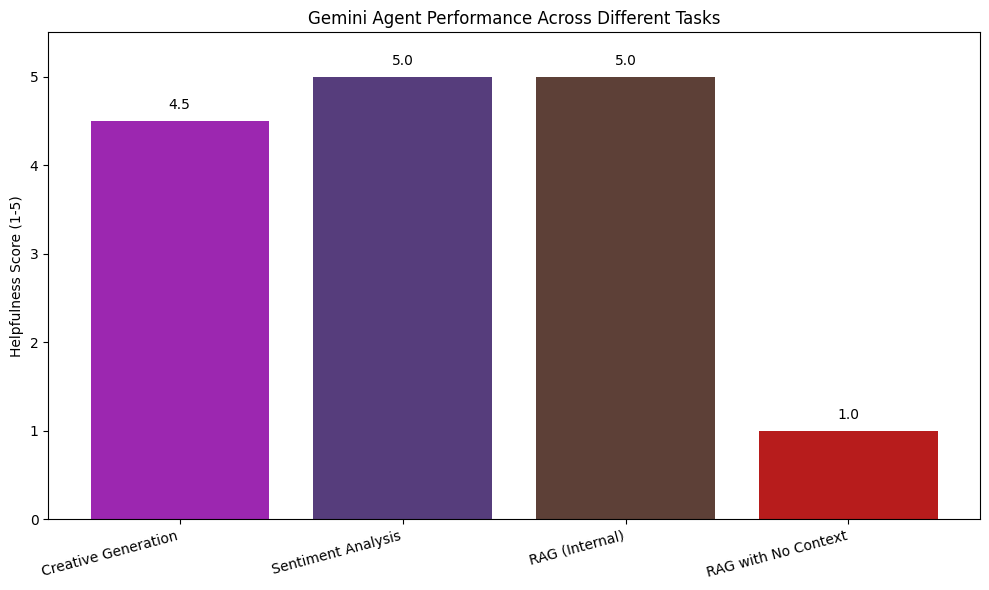

In [31]:
import matplotlib.pyplot as plt
import numpy as np


tasks = ['Creative Generation', 'Sentiment Analysis', 'RAG (Internal)', 'RAG with No Context']
scores = [4.5, 5.0, 5.0, 1.0]


fig, ax = plt.subplots(figsize=(10, 6))
bar_positions = np.arange(len(tasks))
bars = ax.bar(bar_positions, scores, color=['#9c27b0', '#563d7c', '#5d4037', '#b71c1c'])


ax.set_ylabel('Helpfulness Score (1-5)')
ax.set_title('Gemini Agent Performance Across Different Tasks')
ax.set_xticks(bar_positions)
ax.set_xticklabels(tasks, rotation=15, ha="right")
ax.set_ylim(0, 5.5)


for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 1), ha='center', va='bottom')

plt.tight_layout()
plt.show()